<a href="https://colab.research.google.com/github/MateoRivera/network-dynamics/blob/main/H3/H3_Juliana.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1.1.2  Generate a random graph

In [11]:
import networkx as nx
import random

def preferential_attachment_graph(n, k):
    assert n > k + 1, "Number of nodes (n) must be greater than k + 1."

    # Initial complete graph with k + 1 nodes
    G = nx.complete_graph(k + 1)

    # Alternating strategy for odd k
    c_low = k // 2
    c_high = c_low + 1

    # At every time t>=2 create a new graph by adding a new node
    for t in range(k + 2, n + 1):
        G.add_node(t)

        # Calculate the degree of each existing node, serve as wi(t-1)
        degrees = dict(G.degree())
        total_degree = sum(degrees.values())

        # Calculate current average degree
        current_avg_degree = total_degree / G.number_of_nodes()

        # Decide the number of edges to add dynamically
        if current_avg_degree < k:
            c = c_high
        else:
            c = c_low

        # Select nodes to connect based on preferential attachment
        targets = set()

        # Loop helps to avoiding redundant edges to the same target
        while len(targets) < c:

            # Probability of connecting to an existing node is proportional to
            # its current degree wi(t-1)
            chosen = random.choices(
                population=list(degrees.keys()),
                weights=list(degrees.values()),
                k=1
            )[0]
            # Ensure no multiple links to the same node
            if chosen not in targets:
                targets.add(chosen)

        # Add edges between the new node and selected targets
        for target in targets:
            G.add_edge(t, target)


    # Post-generation adjustment to match desired average degree
    """These adjustments are random and might slightly alter the preferential
    attachment structure of the graph, but for large n, their effect is minimal
    because the overall degree distribution and structure remain close to what
    is expected from the preferential attachment model."""

    target_edges = n * k // 2 # Target total number of edges in the graph
    current_edges = G.number_of_edges()

    if current_edges < target_edges:
        while G.number_of_edges() < target_edges:
            u, v = random.sample(G.nodes(), 2)  # Randomly pick two distinct nodes
            if not G.has_edge(u, v): # Ensure there's no edge between them
                G.add_edge(u, v) # Add an edge between them
    elif current_edges > target_edges:
        while G.number_of_edges() > target_edges:
            edge = random.choice(list(G.edges()))  # Randomly pick an existing edge
            G.remove_edge(*edge) # Remove the chosen edge

    return G


Generated graph with average degree: 6.0


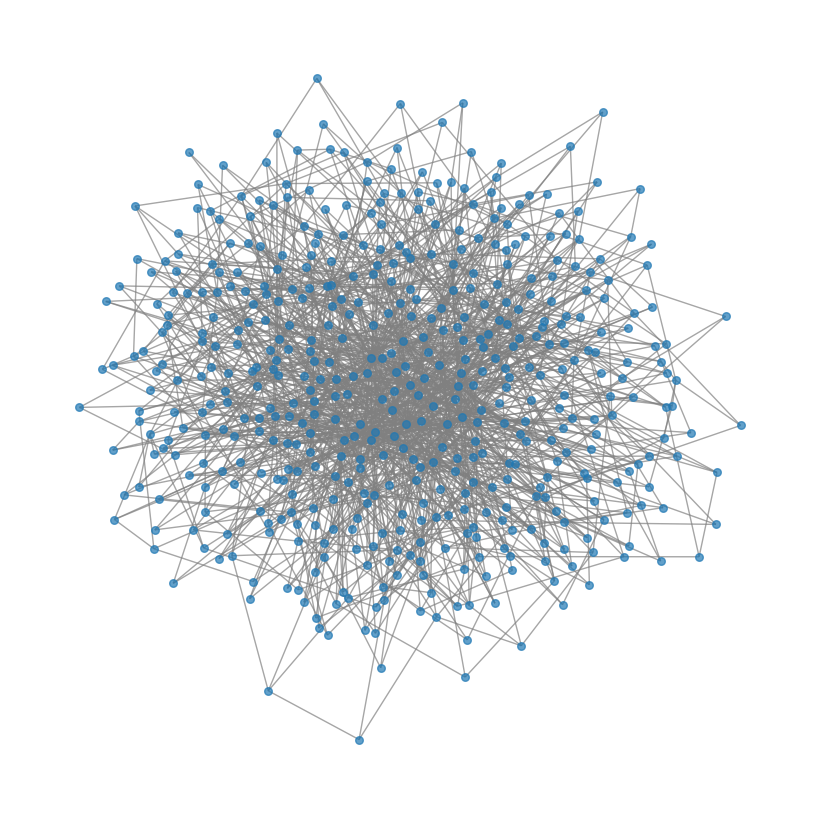

In [12]:
n = 500  # Total number of nodes in the graph.
k = 6    # Desired average degree of the graph.
G = preferential_attachment_graph(n, k)

# Check average degree
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Generated graph with average degree: {average_degree}")

# Visualize the graph (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
nx.draw_spring(G, node_size=30, edge_color='gray', alpha=0.7)
plt.show()

## Problem 1.2

Generated graph with average degree: 6.0


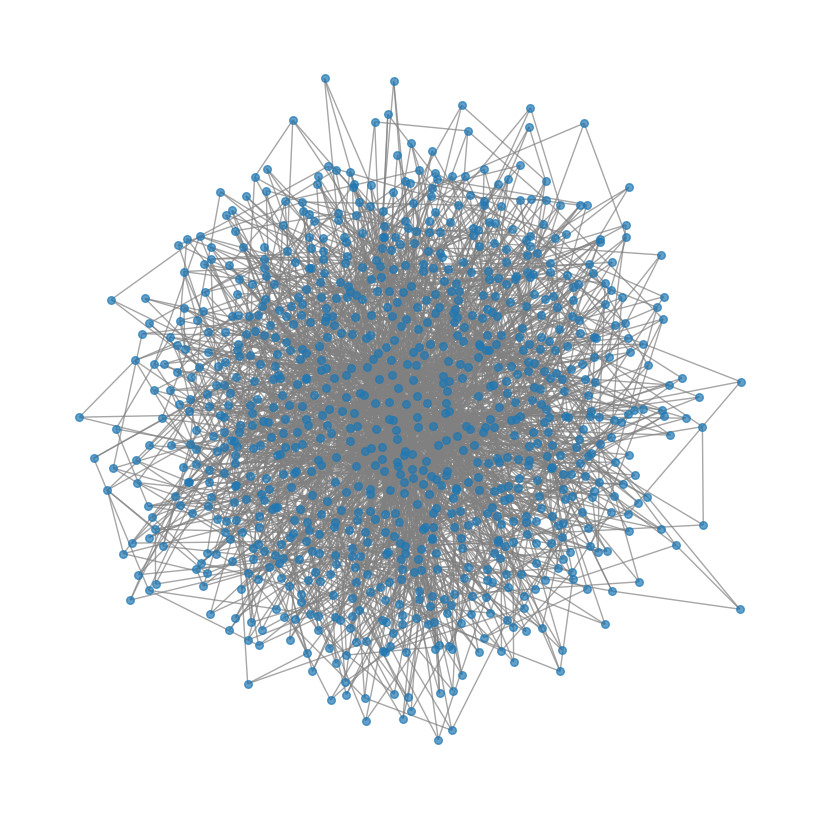

In [3]:
n = 900  # Total number of nodes in the graph.
k = 6    # Desired average degree of the graph.
G = preferential_attachment_graph(n, k)

# Check average degree
average_degree = sum(dict(G.degree()).values()) / G.number_of_nodes()
print(f"Generated graph with average degree: {average_degree}")

# Visualize the graph (optional)
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
nx.draw_spring(G, node_size=30, edge_color='gray', alpha=0.7)
plt.show()

## 1.2 Simulate a pandemic without vaccination

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
%matplotlib inline
options = {
    'node_size': 500,
    'width': 1, # width of the edges,
    'node_color': '#ffffff',
    'node_shape': 'o',
    'edge_color': 'black',
    'font_weight':'normal'
}
import progressbar
import time


In [4]:
# Set parameters
n = 500
k = 6
beta = 0.25
rho = 0.6
week_to_simulate = 15
n_simulations = 100
initial_infected_nodes = np.random.choice(range(n), 10)


In [5]:
# Set up the graph
G = preferential_attachment_graph(n, k)

In [6]:
# Set initial configuration of the node state

states = ['S', 'I', 'R']

for node in initial_infected_nodes:
    G.nodes[node]['state'] = 'I'

for node in G.nodes():
  if node not in initial_infected_nodes:
    G.nodes[node]['state'] = 'S'  # Default state for all nodes is 'S'



In [7]:
# From G, get the infected neighbors of the node i
def get_infected_neighbors(G, i):
    infected_neighbors = [neighbor for neighbor in G.neighbors(i) if G.nodes[neighbor]['state'] == 'I']
    return infected_neighbors

# Computes the probability that individual i becomes infected by any of its neighbors or
# the probability that an infected individual will recover during one time step.
def P(G, i, beta = None, rho = None):
        return 1- (1 - beta) ** len(get_infected_neighbors(G, i)) if beta is not None else rho


'''# Probability functions for infection and recovery
def P(G, i, beta=None, rho=None):
    infected_neighbors = get_infected_neighbors(G, i)
    if beta is not None:
        return 1 - (1 - beta) ** len(infected_neighbors)  # Infection probability
    elif rho is not None:
        return rho  # Recovery probability
    return 0'''

'# Probability functions for infection and recovery\ndef P(G, i, beta=None, rho=None):\n    infected_neighbors = get_infected_neighbors(G, i)\n    if beta is not None:\n        return 1 - (1 - beta) ** len(infected_neighbors)  # Infection probability\n    elif rho is not None:\n        return rho  # Recovery probability\n    return 0'

In [8]:
def EpidemicSimulation(G, beta, rho, time_limit):
    states = ['S', 'I', 'R']
    # We do not want to modify the original graph
    G = G.copy()
    # Create a mapping from node ID to array index
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}

    # nodes_infected saves is a matrix of G.number_of_nodes() X time_limit
    # each row is associated to a node and each column to the state of the node
    #nodes_infected = np.zeros((G.number_of_nodes(), 1))
    # Initialize state array: 0 -> S, 1 -> I, 2 -> R
    nodes_infected = np.array([states.index(G.nodes[i]['state']) for i in G.nodes()], dtype=int).reshape(-1, 1)
    new_nodes_infected = [np.sum(nodes_infected == 1)]  # Initial count of infected nodes


    # Warning: G.nodes[i]['state'] saves the current state, not historical data
    for t in range(1, time_limit + 1):
        # We will be modifying the states of G, so we need a copy of the iteration t - 1
        G_copy = G.copy()
        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)

        # Let's make some transitions depending on the probabilities
        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            idx = node_to_index[i]  # Get the index of node i in nodes_infected

            if new_state == 'S':
                # 1 if i get infected, 0 otherwise
                i_is_infected = np.random.binomial(1, P(G_copy, i, beta = beta))

                if i_is_infected:
                    new_state = 'I'
                    new_nodes_infected[-1] += 1

            elif new_state == 'I':
                # 1 if i get recovered, 0 otherwise
                i_is_recovered = np.random.binomial(1, P(G_copy, i, rho = rho))

                if i_is_recovered:
                    new_state = 'R'

            # Let's update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[i] = states.index(new_state)

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected

In [9]:

def Simulations(G, beta, rho, n_simulations = 100, use_progressbar = True):
    simulations = []
    # Create a progress bar
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)
    for s in range(n_simulations):
        simulations.append(EpidemicSimulation(G, beta, rho, week_to_simulate))
        if use_progressbar:
            bar.update(s+1)
    if use_progressbar:
        bar.finish()
    return simulations

In [ ]:
nodes_infected, new_nodes_infected = EpidemicSimulation(G, beta, rho, week_to_simulate)

S = Simulations(G, beta, rho)

In [ ]:
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)
average_new_nodes_infected

In [ ]:
plt.plot(average_new_nodes_infected)

In [20]:
import networkx as nx
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import progressbar

sns.set()

# Function to generate a preferential attachment graph
def preferential_attachment_graph(n, k):
    assert n > k + 1, "Number of nodes (n) must be greater than k + 1."

    # Initial complete graph with k + 1 nodes
    G = nx.complete_graph(k + 1)

    # At every time t>=2 create a new graph by adding a new node
    for t in range(k + 2, n + 1):
        G.add_node(t)

        # Calculate the degree of each existing node, serve as wi(t-1)
        degrees = dict(G.degree())

        # Select nodes to connect based on preferential attachment
        targets = set()

        # Loop to ensure no redundant edges to the same target
        while len(targets) < k:
            # Probability of connecting to an existing node is proportional to its current degree wi(t-1)
            chosen = random.choices(
                population=list(degrees.keys()),
                weights=list(degrees.values()),
                k=1
            )[0]
            targets.add(chosen)

        # Add edges between the new node and selected targets
        for target in targets:
            G.add_edge(t, target)

    return G


# Function to get infected neighbors of a node
def get_infected_neighbors(G, i):
    return [neighbor for neighbor in G.neighbors(i) if G.nodes[neighbor]['state'] == 'I']

# Function to calculate infection/recovery probability
def P(G, i, beta=None, rho=None):
    infected_neighbors = get_infected_neighbors(G, i)
    if beta is not None:
        return 1 - (1 - beta) ** len(infected_neighbors)  # Infection probability
    elif rho is not None:
        return rho  # Recovery probability
    return 0

def EpidemicSimulation(G, beta, rho, time_limit):
    states = ['S', 'I', 'R']
    G = G.copy()  # Copy the graph to avoid modifying the original

    # Initial state configuration
    node_to_index = {node: idx for idx, node in enumerate(G.nodes())}
    nodes_infected = np.array([states.index(G.nodes[i]['state']) for i in G.nodes()], dtype=int).reshape(-1, 1)
    new_nodes_infected = [np.sum(nodes_infected == 1)]  # Initial count of infected nodes

    for t in range(1, time_limit + 1):
        G_copy = G.copy()
        current_nodes_infected = np.copy(nodes_infected[:, -1])
        new_nodes_infected.append(0)

        for i in G_copy.nodes:
            new_state = G_copy.nodes[i]['state']
            idx = node_to_index[i]  # Get the correct index of node i

            if new_state == 'S':
                # Check if the node gets infected
                if np.random.binomial(1, P(G_copy, i, beta)):
                    new_state = 'I'
                    new_nodes_infected[-1] += 1

            elif new_state == 'I':
                # Check if the node recovers
                if np.random.binomial(1, P(G_copy, i, rho)):
                    new_state = 'R'

            # Update the state of the node
            G.nodes[i]['state'] = new_state
            current_nodes_infected[idx] = states.index(new_state)  # Use the index from node_to_index

        nodes_infected = np.append(nodes_infected, current_nodes_infected.reshape(-1, 1), axis=1)

    return nodes_infected, new_nodes_infected

# Function for running multiple simulations
def Simulations(G, beta, rho, n_simulations=100, use_progressbar=True):
    simulations = []
    if use_progressbar:
        bar = progressbar.ProgressBar(max_value=n_simulations)

    for s in range(n_simulations):
        simulations.append(EpidemicSimulation(G, beta, rho, 15))
        if use_progressbar:
            bar.update(s+1)

    if use_progressbar:
        bar.finish()

    return simulations


# Parameters
n = 500
k = 6
beta = 0.25
rho = 0.6
week_to_simulate = 15
n_simulations = 100
initial_infected_nodes = np.random.choice(range(n), 10)



def custom_circulant_graph(n, k):
    #if condition returns False, AssertionError is raised:
    assert k % 2 == 0, "k must be even, i.e. k ∈ {2i | i ∈ N}"

    # Generate the circulant graph
    distances = [i for i in range(1, k // 2 + 1)]  # Set of distances (1, 2, ..., k/2)
    return nx.circulant_graph(n, distances)

# Generate graph
G = preferential_attachment_graph(n, k)


# Set initial state for nodes
for node in initial_infected_nodes:
    G.nodes[node]['state'] = 'I'

for node in G.nodes():
    if node not in initial_infected_nodes:
        G.nodes[node]['state'] = 'S'  # Default state for non-infected nodes

# Run simulations
S = Simulations(G, beta, rho, n_simulations)

# Calculate the average number of new infected nodes
average_new_nodes_infected = np.mean([simulation[1] for simulation in S], axis=0)

# Output the average new infected nodes per week
print(average_new_nodes_infected)


100% (100 of 100) |######################| Elapsed Time: 0:00:15 Time:  0:00:15


[ 10.    66.51 173.84 148.58  45.58  11.37   5.06   2.84   2.13   1.55
   0.93   0.65   0.45   0.51   0.36   0.18]


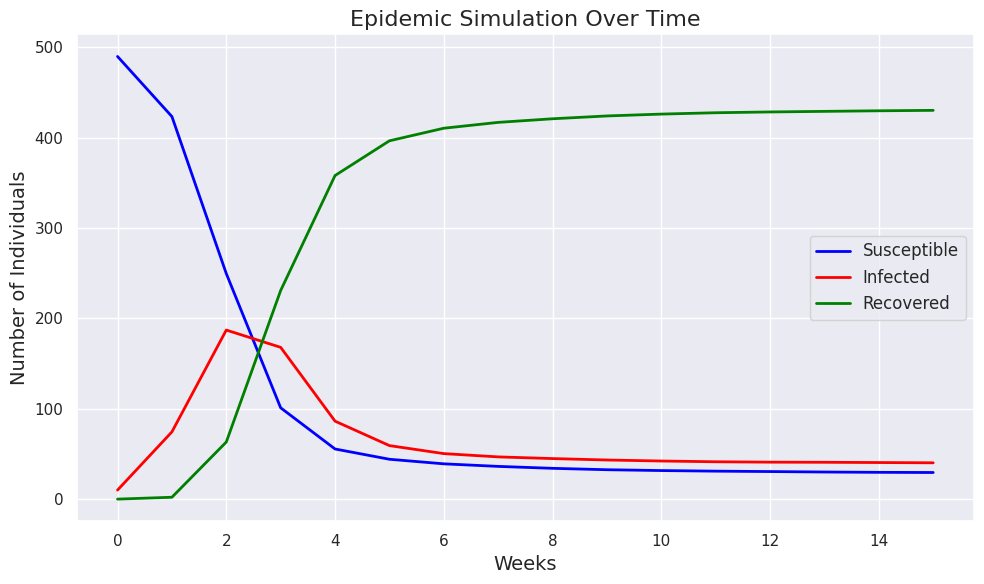

In [22]:
# Extract and calculate the total number of S, I, and R nodes for each week
def calculate_average_states(simulations, G):
    num_nodes = len(G.nodes)
    total_states = np.zeros((3, week_to_simulate + 1))  # For S, I, R

    for simulation in simulations:
        states = simulation[0]  # Get the state history for each node
        for t in range(states.shape[1]):
            total_states[0, t] += np.sum(states[:, t] == 0)  # Susceptible (S)
            total_states[1, t] += np.sum(states[:, t] == 1)  # Infected (I)
            total_states[2, t] += np.sum(states[:, t] == 2)  # Recovered (R)

    # Calculate the average across all simulations
    average_states = total_states / len(simulations)
    return average_states

# Calculate the average states for S, I, R
average_states = calculate_average_states(S, G)

# Plotting the results
time = range(week_to_simulate + 1)
plt.figure(figsize=(10, 6))

plt.plot(time, average_states[0], label='Susceptible', color='blue', linewidth=2)
plt.plot(time, average_states[1], label='Infected', color='red', linewidth=2)
plt.plot(time, average_states[2], label='Recovered', color='green', linewidth=2)

plt.title("Epidemic Simulation Over Time", fontsize=16)
plt.xlabel("Weeks", fontsize=14)
plt.ylabel("Number of Individuals", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.show()

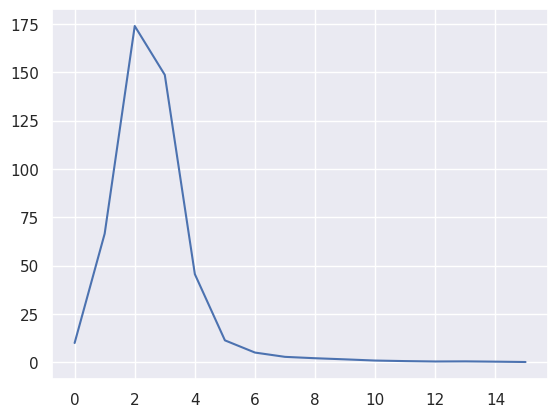

In [21]:
plt.plot(average_new_nodes_infected)